## Binning, Discretization, Linear Models, and Trees

The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using. Linear models and tree-based models (such as decision trees, gradient boosted trees, and random forests), two large and very commonly used families, have very different properties when it comes to how they work with different feature representations. 

Let’s go back to the wave regression dataset that we used in Chapter 2. It has only a single input feature. Here is a comparison of a linear regression model and a decision tree regressor on this dataset:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

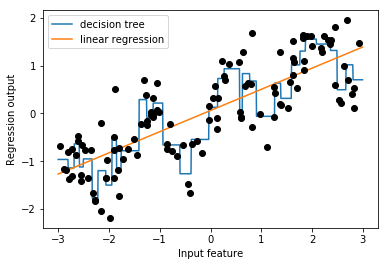

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

As you know, linear models can only model linear relationships, which are lines in the case of a single feature. The decision tree can build a much more complex model of the data. However, this is strongly dependent on the representation of the data. One way to make linear models more powerful on continuous data is to use *binning* (also known as *discretization*) of the feature to split it up into multiple features, as described here.

We imagine a partition of the input range for the feature (in this case, the numbers from –3 to 3) into a fixed number of bins—say, 10. A data point will then be represented by which bin it falls into. There are several ways to define the edges of the bins; for example, giving them uniform width (making the bin edges equidistant) or using quantiles of the data (i.e., having smaller bins where there’s more data). Both of these strategies are implemented in the *KBinsDiscretizer*:

In [3]:
from sklearn.preprocessing import KBinsDiscretizer

In [4]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
       -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
        2.92132162])]


Here, the first bin contains all data points with feature values from -2.967 (the smallest value in the data) to -2.378, the second bin contains all points with feature values from -2.378 to -1.789, and so on. *KBinsDiscretizer* can be applied to multiple features at the same time, and the *bin_edges_* contain the edges per feature. This is why they are a list of length one in this case.

Using *transform*, we can encode each data point by which bin it falls into. By default, *KBinDiscretizer* applies one-hot-encoding to the bins, so there is one new feature per bin, and it produces a sparse matrix. Because we specified 10 bins, the transformed data is ten-dimensional.

In [5]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

We can convert the sparse matrix to a dense array and compare the data points to their encoding:

In [6]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

We can see that the first data point with value -0.753 was put in the 4th bin, the second data point with value 2.704 was put in the 10th bin, and so on.

What we did here is transform the single continuous input feature in the wave dataset into a one-hot encoded categorical feature which encodes which bin a data point is in. You can forego the one-hot-encoding by specifying encode='ordinal' though that is usually less useful. To make things easier for demonstration purposes, we will use encode='onehot-dense' which uses dense one-hot encoding so we can directly print all features.

In [7]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

Now we build a new linear regression model and a new decision tree model on the one-hot-encoded data. The result is visualized here, together with the bin boundaries, shown as dotted black lines:

Text(0.5, 0, 'Input feature')

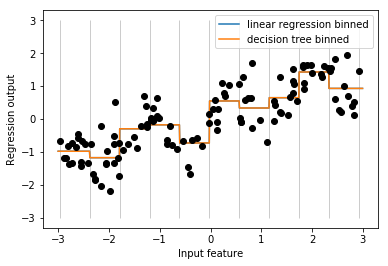

In [8]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)

plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

The dashed line and solid line are exactly on top of each other, meaning the linear regression model and the decision tree make exactly the same predictions. For each bin, they predict a constant value. As features are constant within each bin, any model must predict the same value for all points within a bin. Comparing what the models learned before binning the features and after, we see that the linear model became much more flexible, because it now has a different value for each bin, while the decision tree model got much less flexible. 

Binning features generally has no beneficial effect for tree-based models, as these models can learn to split up the data anywhere. In a sense, that means decision trees can learn whatever binning is most useful for predicting on this data. Additionally, decision trees look at multiple features at once, while binning is usually done on a per-feature basis. However, the linear model benefited greatly in expressiveness from the transformation of the data.

If there are good reasons to use a linear model for a particular dataset—say, because it is very large and high-dimensional, but some features have nonlinear relations with the output—binning can be a great way to increase modeling power.